# ASEWA Project - VGG19
Taking a pretrained VGG19 and performing Style Transfer
---
Janina Klarmann, Laura Kühl

## Setup

In [1]:
import tensorflow as tf
import numpy as np
from torchvision import transforms
import tensorflow_datasets as tfds
from keras.preprocessing.image import ImageDataGenerator
import math

import PIL.Image
import IPython.display as display
import matplotlib.pyplot as plt
import matplotlib as mpl
mpl.rcParams['figure.figsize'] = (12, 12)
mpl.rcParams['axes.grid'] = False

import time
import functools

import tqdm
import datetime

## Image Preprocessing

In [2]:
# Define a function to load an image and limit its maximum dimension to 512 pixels.
def load_img(path_to_img):
  max_dim = 512
  img = tf.io.read_file(path_to_img)
  img = tf.image.decode_image(img, channels=3)
  img = tf.image.convert_image_dtype(img, tf.float32)

  shape = tf.cast(tf.shape(img)[:-1], tf.float32)
  long_dim = max(shape)
  scale = max_dim / long_dim

  new_shape = tf.cast(shape * scale, tf.int32)

  img = tf.image.resize(img, new_shape)
  img = img[tf.newaxis, :]
  return img

In [3]:
content_path = tf.keras.utils.get_file('YellowLabradorLooking_new.jpg', 'https://storage.googleapis.com/download.tensorflow.org/example_images/YellowLabradorLooking_new.jpg')
style_path = style_path = tf.keras.utils.get_file('kandinsky5.jpg','https://storage.googleapis.com/download.tensorflow.org/example_images/Vassily_Kandinsky%2C_1913_-_Composition_7.jpg')

204800/195196 [===============================] - 0s 0us/step


In [4]:
content_image = load_img(content_path)
style_image = load_img(style_path)

## Layers

In [5]:
style_layers_vgg19 = ['block1_conv1','block2_conv1','block3_conv1','block4_conv1', 'block5_conv1']
content_layer_vgg19 = ['block5_conv4']

## Perform Style Transfer

### Models

In [6]:
from tensorflow.python.tools import module_util
def VGG19_Model(layer_names):
  """ Creates our model with access to intermediate layers. 
  
  This function will load the VGG19 model and access the intermediate layers. 
  These layers will then be used to create a new model that will take input image
  and return the outputs from these intermediate layers from the VGG model. 
  
  Returns:
    returns a keras model that takes image inputs and outputs the style and 
      content intermediate layers. 
  """
  # Load our model. We load pretrained VGG, trained on imagenet data (weights=’imagenet’)
  vgg19 = tf.keras.applications.VGG19(include_top=False, weights='imagenet')
  vgg19.trainable = False
  # Get output layers corresponding to style and content layers 
  outputs = [vgg19.get_layer(name).output for name in layer_names]
  # Build model 
  model = tf.keras.Model([vgg19.input], outputs)

  return model 

In [7]:
class StyleExtractionModelVGG19(tf.keras.models.Model):
  def __init__(self, style_layers, content_layers):
    super(StyleExtractionModelVGG19, self).__init__()
    self.vgg19_again = VGG19_Model(style_layers+content_layers)
    self.style_layers = style_layers
    self.content_layers = content_layers
    self.num_style_layers = len(style_layers)
    self.vgg19_again.trainable = False 

  def gram_matrix(self, input_tensor):
    result = tf.linalg.einsum('bijc,bijd->bcd', input_tensor, input_tensor)
    input_shape = tf.shape(input_tensor)
    num_locations = tf.cast(input_shape[1]*input_shape[2], tf.float32)
    return result/(num_locations)

  def call(self, inputs):
    "Expects float input in [0,1]"
    inputs = inputs*255.0
    preprocessed_input = tf.keras.applications.vgg19.preprocess_input(inputs)
    # preprocessed_input = tf.reshape(preprocessed_input, [-1, 32, 32, 3])
    outputs = self.vgg19_again(preprocessed_input)
    style_outputs, content_outputs = (outputs[:self.num_style_layers],
                                      outputs[self.num_style_layers:])

    style_outputs = [self.gram_matrix(style_output)
                    for style_output in style_outputs]

    content_dict = {content_name: value
                    for content_name, value
                    in zip(self.content_layers, content_outputs)}

    style_dict = {style_name: value
                  for style_name, value
                  in zip(self.style_layers, style_outputs)}

    return {'content': content_dict, 'style': style_dict}

In [8]:
class StyleTrainingModelVGG19(tf.keras.models.Model):
  def __init__(self, style_layers, content_layers):
    super(StyleTrainingModelVGG19, self).__init__()
    self.ExtractionModel = StyleExtractionModelVGG19(style_layers, content_layers)
    self.opt = tf.optimizers.Adam(learning_rate=0.02, beta_1=0.99, epsilon=1e-1)
    self.style_weight = 1e-2
    self.content_weight = 1e4
    self.style_targets = self.ExtractionModel(style_image)['style']
    self.content_targets = self.ExtractionModel(content_image)['content']
    self.num_style_layers = len(style_layers)
    self.num_content_layers = len(content_layers)

  def clip_0_1(self, image):
    return tf.clip_by_value(image, clip_value_min=0.0, clip_value_max=1.0)

  def tensor_to_image(self, tensor):
    tensor = tensor*255
    tensor = np.array(tensor, dtype=np.uint8)
    if np.ndim(tensor)>3:
      assert tensor.shape[0] == 1
      tensor = tensor[0]
    return PIL.Image.fromarray(tensor)
 
  def style_content_loss(self, outputs):
    style_outputs = outputs['style']
    content_outputs = outputs['content']
    style_loss = tf.add_n([tf.reduce_mean((style_outputs[name]-self.style_targets[name])**2) 
                          for name in style_outputs.keys()])
    style_loss *= self.style_weight / self.num_style_layers

    content_loss = tf.add_n([tf.reduce_mean((content_outputs[name]-self.content_targets[name])**2) 
                            for name in content_outputs.keys()])
    content_loss *= self.content_weight / self.num_content_layers
    loss = style_loss + content_loss
    return loss

  @tf.function()
  def train_step(self, img):
    with tf.GradientTape() as tape:
      outputs = self.ExtractionModel(img)
      loss = self.style_content_loss(outputs)

    grad = tape.gradient(loss, img)
    self.opt.apply_gradients([(grad, img)])
    img.assign(self.clip_0_1(img))

### Image Trainingsteps

In [9]:
MyModelVGG19 = StyleTrainingModelVGG19(style_layers_vgg19, content_layer_vgg19)
image = tf.Variable(content_image)

for i in range(100):
  print(f'Working on Trainingstep {i}...')
  MyModelVGG19.train_step(image)
print('Trainingsteps Done')

80150528/80134624 [==============================] - 1s 0us/step
Working on Trainingstep 0...
Working on Trainingstep 1...
Working on Trainingstep 2...
Working on Trainingstep 3...
Working on Trainingstep 4...
Working on Trainingstep 5...
Working on Trainingstep 6...
Working on Trainingstep 7...
Working on Trainingstep 8...
Working on Trainingstep 9...
Working on Trainingstep 10...
Working on Trainingstep 11...
Working on Trainingstep 12...
Working on Trainingstep 13...
Working on Trainingstep 14...
Working on Trainingstep 15...
Working on Trainingstep 16...
Working on Trainingstep 17...
Working on Trainingstep 18...
Working on Trainingstep 19...
Working on Trainingstep 20...
Working on Trainingstep 21...
Working on Trainingstep 22...
Working on Trainingstep 23...
Working on Trainingstep 24...
Working on Trainingstep 25...
Working on Trainingstep 26...
Working on Trainingstep 27...
Working on Trainingstep 28...
Working on Trainingstep 29...
Working on Trainingstep 30...
Working on Trai

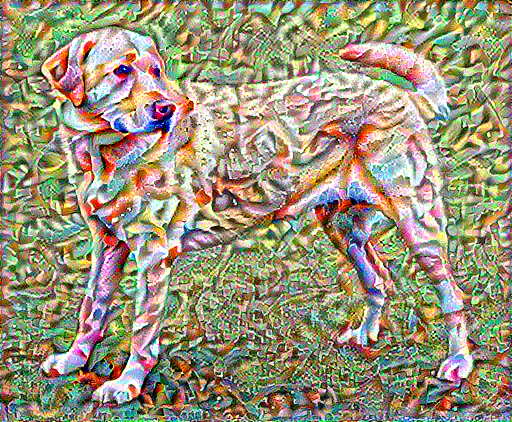

In [10]:
final_image = MyModelVGG19.tensor_to_image(image)
final_image